## Yapay Sinir Ağını Eğitmek

1. Başlangıç ağırlıklarının rasgele atanması
2. İleri yayılım algoritması kullanarak her bir $x^{(i)}$ için $h_\Theta(x^{(i)})$ hesaplanır
3. Bedel fonksiyonu 
4. Kısmi türev uygulanarak geri yayılımlı algoritmasını uygulanır
5. Dereceli kontrol algoritması kullanılarak geri yayılım algoritmasının çalışması kontrol edilir,
    model kullanılırken kullanılmamalı.
6. Dereceli eğilimli alçalma veya optimizasyon fonksiyonu kullanarak bedel fonksiyonun minimizasyonu sağlanır.

In [2]:
from scipy.io import loadmat ## mat dosyasını okumayabilmek için gerekli
import numpy as np
import scipy.misc 
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import random

In [4]:
# verinin okunması

veri = loadmat('data/ex4data1.mat')

X = veri['X']
y = veri['y']
        
## thetaların yüklenmesi
mat2=loadmat("data/ex4weights.mat")

Theta1=mat2["Theta1"] # Theta1 boyutu 25 x 401  hidden layer 25 boğuma sahip
Theta2=mat2["Theta2"] # Theta2 boyutu 10 x 26 output olarak 10 sınıf ve hidden layer da 25+1 bias ile 26 boğum 


In [5]:
print("'y' boyutu: %s. y'nin tekil etiketleri: %s"%(veri['y'].shape,np.unique(veri['y'])))
print("'X' boyutu:",veri['X'].shape)
print("Thera1 boyutu:",Theta1.shape)
print("Thera2 boyutu:",Theta2.shape)

'y' boyutu: (5000, 1). y'nin tekil etiketleri: [ 1  2  3  4  5  6  7  8  9 10]
'X' boyutu: (5000, 400)
Thera1 boyutu: (25, 401)
Thera2 boyutu: (10, 26)


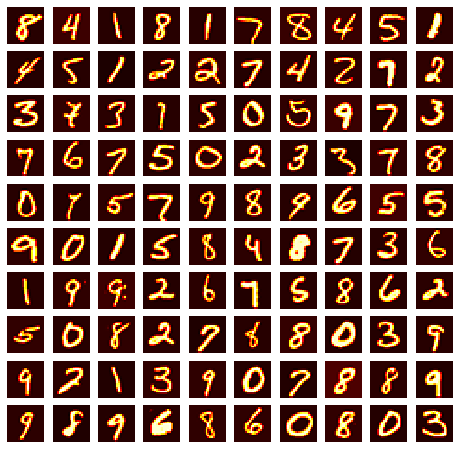

In [3]:
# verinin görselleştirilmesi
import matplotlib.image as mpimg
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        #veriyi 20x20 pixel boyutuna geri getirir
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") 
        axis[i,j].axis("off")

In [4]:
## sigmoid fonksiyonunun tanımlanması
def sigmoid(z):    
    return 1/ (1 + np.exp(-z))


## Forward Propagation Maliyet Fonksiyonunun Hesaplanması <br>
$$J(\Theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\Theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\Theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2]$$ <br><br>


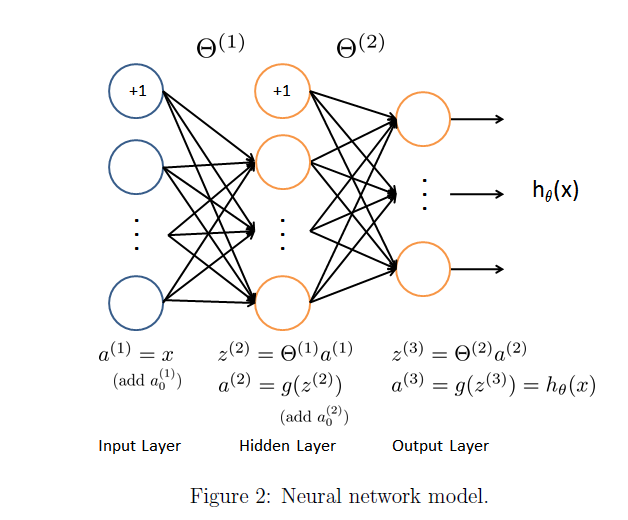<br>


In [6]:
girdi_katmani_boyutu  = 400
ara_katman_boyutu = 25
etiket_sayisi = 10 

nn_params = np.append(Theta1.flatten(),Theta2.flatten())

In [18]:
def sigmoidDereceli(z):
    sigmoid = 1/(1 + np.exp(-z))    
    return sigmoid *(1-sigmoid)

In [13]:
def ysaBedelFonk(nn_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y, Lambda,flag):
    if flag == 1:
        theta1 = np.reshape(nn_params[:ara_katman_boyutu*(girdi_katmani_boyutu+1)], (ara_katman_boyutu, girdi_katmani_boyutu+1), 'F')
        theta2 = np.reshape(nn_params[ara_katman_boyutu*(girdi_katmani_boyutu+1):], (etiket_sayisi, ara_katman_boyutu+1), 'F')
    else:
        theta1 = nn_params[:((girdi_katmani_boyutu+1)*ara_katman_boyutu)].reshape(ara_katman_boyutu,girdi_katmani_boyutu+1)
        theta2 = nn_params[((girdi_katmani_boyutu +1)*ara_katman_boyutu ):].reshape(etiket_sayisi,ara_katman_boyutu+1)
         
    m = len(y)
    birler = np.ones((m,1))
    a1 = np.hstack((birler, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((birler, a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten()) # kategorik değişkeleri encode ederek matrise çevirir. 
                                      # K=10 olan etiketlerden herbirini bir kolona etiketleyerek çalışır.
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    toplam1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    toplam2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (toplam1 + toplam2) * Lambda / (2*m)


In [14]:
bedel = ysaBedelFonk(nn_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y,0,0)
reg_Bedel = ysaBedelFonk(nn_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y,1,0)

print("Maliyet değeri (regulasyon olmadan):",bedel,"\nMaliyet değeri (regulasyonlu):",reg_Bedel)

Maliyet değeri (regulasyon olmadan): 0.28762916516131876 
Maliyet değeri (regulasyonlu): 0.3837698590909235


In [19]:
def ysaGeriYayilim(nn_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y, lmbda,flag):
    if flag ==0:
        baslangic_theta1 = nn_params[:((girdi_katmani_boyutu+1) * ara_katman_boyutu)].reshape(ara_katman_boyutu,girdi_katmani_boyutu+1)
        baslangic_theta2 = nn_params[((girdi_katmani_boyutu+1)* ara_katman_boyutu ):].reshape(etiket_sayisi,ara_katman_boyutu+1)
    else:
        baslangic_theta1 = np.reshape(nn_params[:ara_katman_boyutu*(girdi_katmani_boyutu+1)], (ara_katman_boyutu, girdi_katmani_boyutu+1), 'F')
        baslangic_theta2 = np.reshape(nn_params[ara_katman_boyutu*(girdi_katmani_boyutu+1):], (etiket_sayisi, ara_katman_boyutu+1), 'F')
    
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(baslangic_theta1.shape)
    delta2 = np.zeros(baslangic_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        # ileri yayılım algoritmasının uygulanması
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ baslangic_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ baslangic_theta2.T
        a3 = sigmoid(z3)
        # geri yayılım algoritmasının uygulanması
        d3 = a3 - y_d.iloc[i,:][np.newaxis,:] # datayı satır indisi ile seç
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(baslangic_theta2.T @ d3.T, sigmoidDereceli(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    delta1[:,1:] = delta1[:,1:] + baslangic_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + baslangic_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

In [16]:
def dereceliKontrolu(nn_baslangic_params,nn_geriyayilim_Params,girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi,myX,myy,mylambda=0.):
    eps = 0.0001
    n_elems = len(nn_baslangic_params) 
    # Veri setinden rasgele seçilim ile numerical gradient hesaplanır ver D ile karşılaştırılır
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = eps

        bedel_yuksek = ysaBedelFonk(nn_baslangic_params + epsvec.flatten(),girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi,myX,myy,mylambda,1)
        bedel_alcak  = ysaBedelFonk(nn_baslangic_params - epsvec.flatten(),girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi,myX,myy,mylambda,1)
       
        kontrolDereceli = (bedel_yuksek - bedel_alcak) / float(2*eps)
        fark = kontrolDereceli- nn_geriyayilim_Params[x]
        print("Eleman: {0}. Dereceli Kontrol = {1:.9f}. Geri Yayılım Dereceli = {2:.9f}. Fark ={3:.9f}. ".format(x,kontrolDereceli,nn_geriyayilim_Params[x],abs(fark)))
       


In [20]:
nn_geriyaylim  = ysaGeriYayilim(nn_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y, 1,1)
dereceliKontrolu(nn_params,nn_geriyaylim,girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi,X,y,1)

Eleman: 9048. Dereceli Kontrol = -0.000007007. Geri Yayılım Dereceli = -0.000007007. Fark =0.000000000. 
Eleman: 550. Dereceli Kontrol = 0.000021807. Geri Yayılım Dereceli = 0.000021807. Fark =0.000000000. 
Eleman: 422. Dereceli Kontrol = -0.000002029. Geri Yayılım Dereceli = -0.000002029. Fark =0.000000000. 
Eleman: 2878. Dereceli Kontrol = -0.000918179. Geri Yayılım Dereceli = -0.000918179. Fark =0.000000000. 
Eleman: 6341. Dereceli Kontrol = 0.068415085. Geri Yayılım Dereceli = 0.068415085. Fark =0.000000000. 
Eleman: 5261. Dereceli Kontrol = 0.039122860. Geri Yayılım Dereceli = 0.039122860. Fark =0.000000000. 
Eleman: 8890. Dereceli Kontrol = 0.003681672. Geri Yayılım Dereceli = 0.003681672. Fark =0.000000000. 
Eleman: 1412. Dereceli Kontrol = 0.001017896. Geri Yayılım Dereceli = 0.001017896. Fark =0.000000000. 
Eleman: 2062. Dereceli Kontrol = 0.000002245. Geri Yayılım Dereceli = 0.000002245. Fark =0.000000000. 
Eleman: 1060. Dereceli Kontrol = 0.000041123. Geri Yayılım Dereceli =

In [21]:
def tahminFonk(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1


In [33]:
tahmin = tahminFonk(Theta1, Theta2, X, y)
np.mean(tahmin == y.flatten()) * 100

97.52

In [ ]:
############################################33

In [22]:
def randBaslangicAgirliklari(L_in, L_out):
    epsilon = 0.12
    random.seed(1234)
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

In [23]:
baslangic_theta1 = randBaslangicAgirliklari(girdi_katmani_boyutu, ara_katman_boyutu)
baslangic_theta2 = randBaslangicAgirliklari(ara_katman_boyutu, etiket_sayisi)

nn_baslangic_params = np.hstack((baslangic_theta1.ravel(order='F'), baslangic_theta2.ravel(order='F')))
nn_geriyayilim_Params = ysaGeriYayilim(nn_baslangic_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y, 1,1)

In [24]:
bedel = ysaBedelFonk(nn_baslangic_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y,0,1)
reg_Bedel = ysaBedelFonk(nn_baslangic_params, girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y,1,1)

print("Maliyet değeri (regulasyonlu):",bedel,"\nMaliyet değeri (regulasyon olmadan):",reg_Bedel)

Maliyet değeri (regulasyonlu): 6.860723104760747 
Maliyet değeri (regulasyon olmadan): 6.865622985604259


In [26]:
dereceliKontrolu(nn_baslangic_params,nn_geriyayilim_Params,girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi,X,y,1)


Eleman: 6272. Dereceli Kontrol = 0.016417297. Geri Yayılım Dereceli = 0.016417297. Fark =0.000000000. 
Eleman: 3714. Dereceli Kontrol = -0.008915102. Geri Yayılım Dereceli = -0.008915102. Fark =0.000000000. 
Eleman: 7908. Dereceli Kontrol = 0.000890193. Geri Yayılım Dereceli = 0.000890193. Fark =0.000000000. 
Eleman: 6473. Dereceli Kontrol = -0.001436122. Geri Yayılım Dereceli = -0.001436122. Fark =0.000000000. 
Eleman: 10180. Dereceli Kontrol = 0.244617511. Geri Yayılım Dereceli = 0.244617511. Fark =0.000000000. 
Eleman: 1286. Dereceli Kontrol = 0.000082362. Geri Yayılım Dereceli = 0.000082362. Fark =0.000000000. 
Eleman: 9514. Dereceli Kontrol = 0.000014025. Geri Yayılım Dereceli = 0.000014025. Fark =0.000000000. 
Eleman: 1509. Dereceli Kontrol = -0.000017467. Geri Yayılım Dereceli = -0.000017467. Fark =0.000000000. 
Eleman: 835. Dereceli Kontrol = -0.000024214. Geri Yayılım Dereceli = -0.000024214. Fark =0.000000000. 
Eleman: 10060. Dereceli Kontrol = 0.173220596. Geri Yayılım Derec

In [27]:
theta_opt = opt.fmin_cg(maxiter = 50, f = ysaBedelFonk, x0 = nn_baslangic_params, fprime = ysaGeriYayilim, \
                        args = (girdi_katmani_boyutu, ara_katman_boyutu, etiket_sayisi, X, y.flatten(), 1,1))

         Current function value: 0.471085
         Iterations: 50
         Function evaluations: 109
         Gradient evaluations: 109


In [28]:
theta1_opt = np.reshape(theta_opt[:ara_katman_boyutu*(girdi_katmani_boyutu+1)], (ara_katman_boyutu, girdi_katmani_boyutu+1), 'F')
theta2_opt = np.reshape(theta_opt[ara_katman_boyutu*(girdi_katmani_boyutu+1):], (etiket_sayisi, ara_katman_boyutu+1), 'F')

In [29]:
tahmin_opt = tahminFonk(theta1_opt, theta2_opt, X, y)
np.mean(tahmin_opt == y.flatten()) * 100

95.86

In [30]:
def tekliGoster(tahmin,indis):
    for x in range(5):
        i = random.choice(indis)
        fig = plt.figure(figsize=(3,3))
        width, height = 20, 20
        square = X[i][0:].reshape(width,height)
        img = scipy.misc.toimage(square.T)
        plt.imshow(img,  cmap="hot")
        fig.suptitle('Tahmin: %d , Gerçek Değer: %d '%(tahmin[i],y[i]), fontsize=14, fontweight='bold')

In [34]:
dogru_tahminler = []
for i in range(X.shape[0]):
    if tahmin[i] == int(y[i]):
        dogru_tahminler.append(i)

D:\programfiles\anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


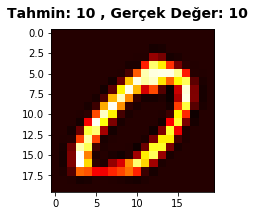

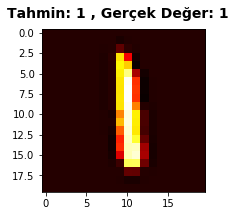

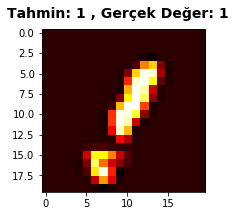

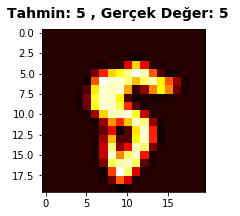

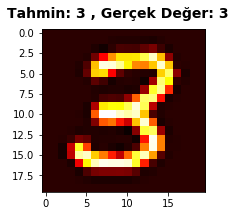

In [36]:
tekliGoster(tahmin,dogru_tahminler)

In [53]:
hatali_tahminler= []
for i in range(X.shape[0]):
    if tahmin[i] != int(y[i]):
        hatali_tahminler.append(i)

C:\Users\DIPRBAYINDIR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


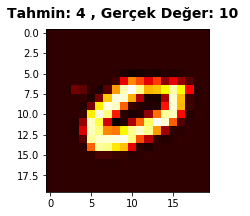

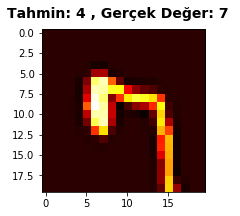

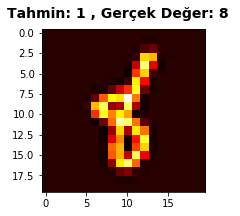

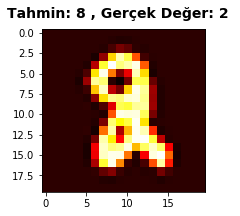

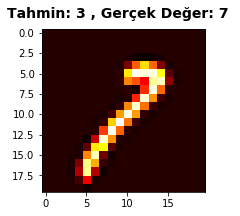

In [54]:
tekliGoster(tahmin,hatali_tahminler)

In [37]:
dogru_tahminler= []
for i in range(X.shape[0]):
    if tahmin_opt[i] == int(y[i]):
        dogru_tahminler.append(i)

D:\programfiles\anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


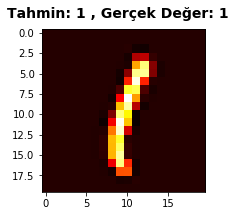

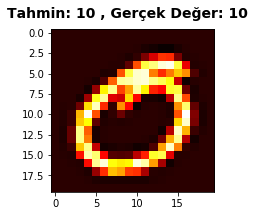

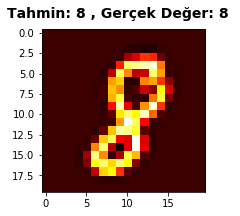

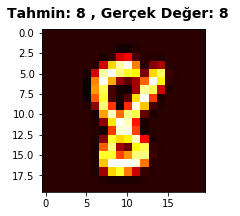

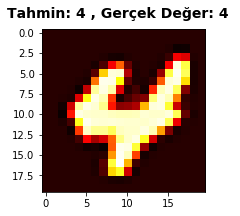

In [41]:
tekliGoster(tahmin_opt,dogru_tahminler)

In [39]:
hatali_tahminler= []
for i in range(X.shape[0]):
    if tahmin_opt[i] != int(y[i]):
        hatali_tahminler.append(i)

D:\programfiles\anaconda\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


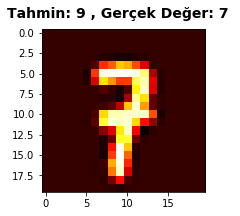

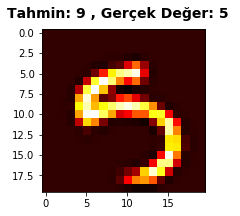

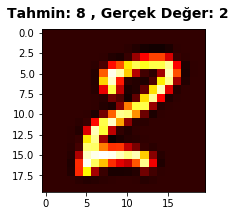

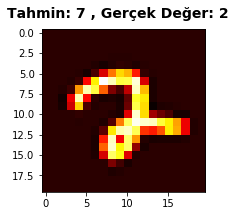

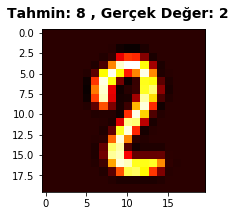

In [40]:
tekliGoster(tahmin_opt,hatali_tahminler)